In [2]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev

Get:1 http://ports.ubuntu.com/ubuntu-ports jammy InRelease [270 kB]
Get:2 http://ports.ubuntu.com/ubuntu-ports jammy-updates InRelease [128 kB]
Get:3 http://ports.ubuntu.com/ubuntu-ports jammy-backports InRelease [127 kB]
Get:4 http://ports.ubuntu.com/ubuntu-ports jammy-security InRelease [129 kB]
Get:5 http://ports.ubuntu.com/ubuntu-ports jammy/multiverse arm64 Packages [224 kB]
Get:6 http://ports.ubuntu.com/ubuntu-ports jammy/universe arm64 Packages [17.2 MB]
Get:7 http://ports.ubuntu.com/ubuntu-ports jammy/restricted arm64 Packages [24.2 kB]
Get:8 http://ports.ubuntu.com/ubuntu-ports jammy/main arm64 Packages [1,758 kB]
Get:9 http://ports.ubuntu.com/ubuntu-ports jammy-updates/multiverse arm64 Packages [29.5 kB]
Get:10 http://ports.ubuntu.com/ubuntu-ports jammy-updates/restricted arm64 Packages [2,349 kB]
Get:11 http://ports.ubuntu.com/ubuntu-ports jammy-updates/universe arm64 Packages [1,362 kB]
Get:12 http://ports.ubuntu.com/ubuntu-ports jammy-updates/main arm64 Packages [2,175 kB]

In [3]:
!pip install tensorflow --upgrade
!pip install scikit-image --upgrade
!pip install tf-agents
!pip install pyglet xvfbwrapper
!pip install tf-keras
!pip install keras-tuner
!pip install pandas pandas-ta numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 MB 2.5 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 8.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.4/319.4 kB 8.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-d

In [3]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [4]:
import tensorflow as tf
from packaging import version

print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

TensorFlow version:  2.17.0


In [48]:
from utils import load_dataset
from envs.combined_env import CombinedEnv
from tf_agents.environments import tf_py_environment

# ====================================== Helper for Simulation ======================================

scenario_raw_env = CombinedEnv(
    #df = load_dataset('./resources/TSLA.csv'), # TSLA
    df = load_dataset('./resources/BABA.csv'), # BABA
    window_size = 10,
    #frame_bound = (1265,1625) # TSLA alcista
    #frame_bound = (1820,2180) # TSLA bajista 
    #frame_bound = (100,475) # TSLA neutro
    #frame_bound = (350,720) # BABA alcista
    #frame_bound = (1580,1950) # BABA bajista
    frame_bound = (2300,2670) # BABA neutro
)

scenario_env = tf_py_environment.TFPyEnvironment(scenario_raw_env)

''' helper function for running the agent through the environment'''
def test_scenario(policy, filename):
    time_step = scenario_env.reset()
    while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = scenario_env.step(action_step.action)
    plt.figure(figsize=(15, 8))
    scenario_raw_env.save_render(filename)

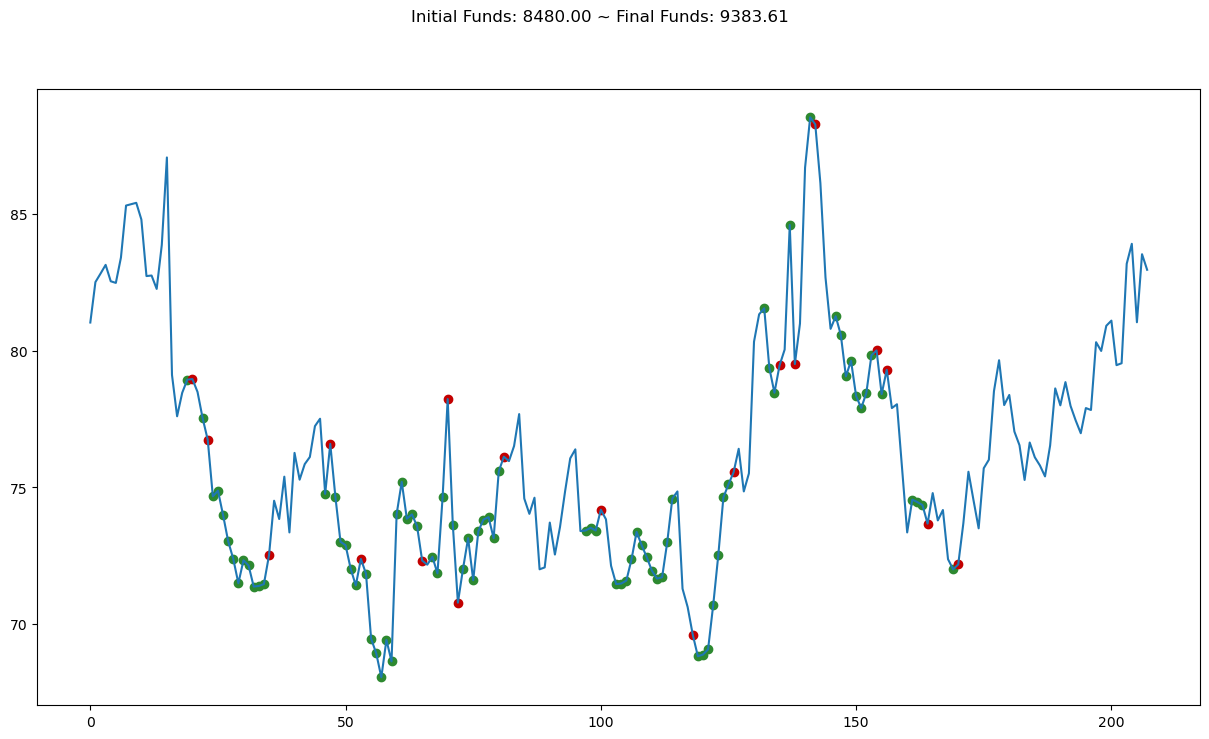

In [49]:
import tensorflow as tf
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
import matplotlib.pyplot as plt


PARAM_NUM_ATOMS = 51
PARAM_MIN_Q_VALUE = -1000
PARAM_MAX_Q_VALUE = 1000
PARAM_N_STEP_UPDATE = 1

# Variables by agent
PARAMS_BY_AGENT = {
    '2024-08-07_114123@trial_010': {
        'LAYERS': (96,320,64),
        'LRATE': 5e-05
    },
    '2024-08-07_222045@trial_14': {
        'LAYERS': (160,32,448,512,384),
        'LRATE': 5e-05
    },
    '2024-08-08_125403@trial_48': {
        'LAYERS': (288,288,192,96,96,32,352,416,96,448,288),
        'LRATE': 5e-05
    }
}

AGENT_ID = '2024-08-08_125403@trial_48'

CHECKPOINT_DIR = './checkpoints/check_2'

# ====================================== Agent initialization and loading in memory ======================================
train_env_sample = scenario_env

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=PARAMS_BY_AGENT[AGENT_ID]['LRATE'])

categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env_sample.observation_spec(),
    train_env_sample.action_spec(),
    num_atoms=PARAM_NUM_ATOMS,
    fc_layer_params=PARAMS_BY_AGENT[AGENT_ID]['LAYERS'])

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env_sample.time_step_spec(),
    train_env_sample.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=PARAM_MIN_Q_VALUE,
    max_q_value=PARAM_MAX_Q_VALUE,
    n_step_update=PARAM_N_STEP_UPDATE,
    # td_errors_loss_fn=common.element_wise_squared_loss, use default error
    gamma=0,
    train_step_counter=tf.Variable(initial_value=0, dtype='int64'))

agent.initialize()

# Restore the checkpoint
checkpoint = tf.train.Checkpoint(agent=agent)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, CHECKPOINT_DIR, max_to_keep=1)

# Restore the latest checkpoint
checkpoint.restore(checkpoint_manager.latest_checkpoint).expect_partial()



## Running test

test_scenario(agent.policy, './evals/test_script.jpg')